In [53]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from sklearn.model_selection import train_test_split
from itertools import product


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [21]:
import missingno as msno

In [22]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
def print_nulls(df):
    out = pd.Series({'Column': 'Percentage of nulls', '-----' : '-----'}
                   ).append(df.isnull().sum()*100/df.isnull().isnull().count())
   
    return print_full(out)

#### The [dataset](https://www.kaggle.com/mczielinski/bitcoin-historical-data) is from kaggle.

In [23]:
df = pd.read_csv('bitcoin.csv')

In [24]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df.columns = [col.lower() for col in df.columns]

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572257 entries, 0 to 4572256
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   timestamp          int64  
 1   open               float64
 2   high               float64
 3   low                float64
 4   close              float64
 5   volume_(btc)       float64
 6   volume_(currency)  float64
 7   weighted_price     float64
dtypes: float64(7), int64(1)
memory usage: 279.1 MB


In [27]:
# Unix-time to 
df.timestamp = pd.to_datetime(df.timestamp, unit='s')

# Resampling to daily frequency
df.index = df.timestamp
df = df.resample('D').mean()

df_month = df.resample('M').mean()

In [28]:
print_nulls(df_month)

Column               Percentage of nulls
-----                              -----
open                                   0
high                                   0
low                                    0
close                                  0
volume_(btc)                           0
volume_(currency)                      0
weighted_price                         0
dtype: object


In [ ]:
#msno.matrix(df)

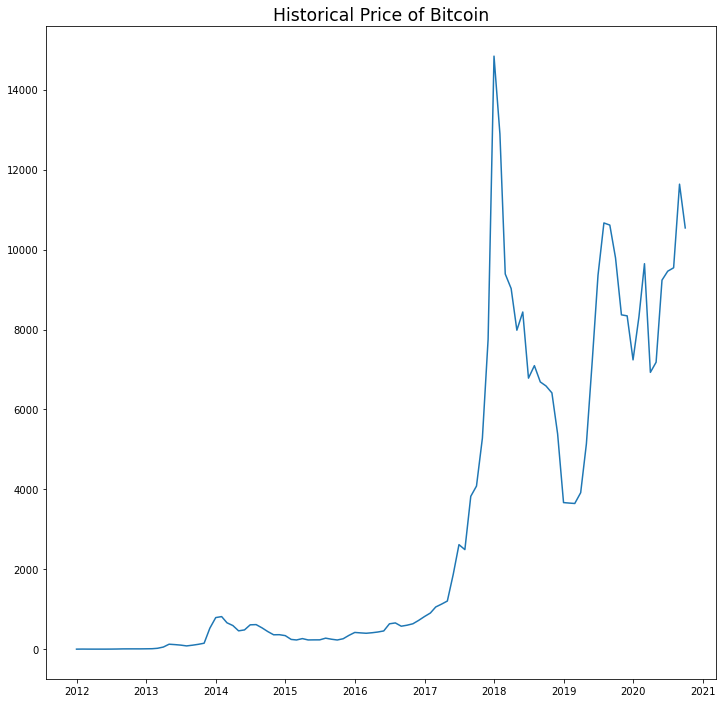

In [38]:
plt.figure(figsize=(12,12))
plt.plot(df_month.weighted_price)
plt.title('Historical Price of Bitcoin', size='xx-large')
plt.show()

In [30]:
# Test to see if the dataset are stationary
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.weighted_price)[1])

Dickey–Fuller test: p=0.617866


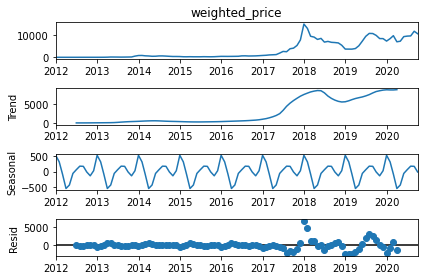

In [35]:
#fig = plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(df_month.weighted_price).plot()
plt.show()

In [36]:
df_month['weighted_price_box'], lmbda = stats.boxcox(df_month.weighted_price)

In [37]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.weighted_price_box)[1])
plt.show()

Dickey–Fuller test: p=0.665427


<Figure size 1080x504 with 0 Axes>

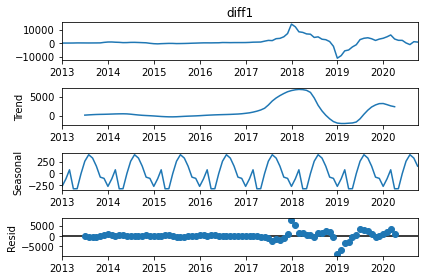

In [45]:
# Calculate the first difference
df_month['diff1'] = df_month['weighted_price'] - df_month['weighted_price'].shift(12)

plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(df_month.diff1[12:]).plot()
plt.show()
snippet = '''
plt.figure(figsize=(12,12))
plt.plot(df_month.diff1)
plt.title('First Difference of Price of Bitcoin')
plt.show()
'''

In [46]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.diff1[12:])[1])
plt.show()

Dickey–Fuller test: p=0.226292


<Figure size 1080x504 with 0 Axes>

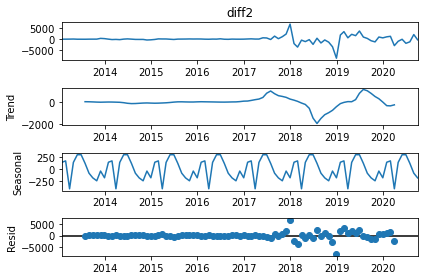

In [47]:
# Calculate the second difference
df_month['diff2'] = df_month['diff1'] - df_month['diff1'].shift(1)

plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(df_month.diff2[13:]).plot()
plt.show()

In [48]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.diff2[13:])[1])
plt.show()

Dickey–Fuller test: p=0.000022


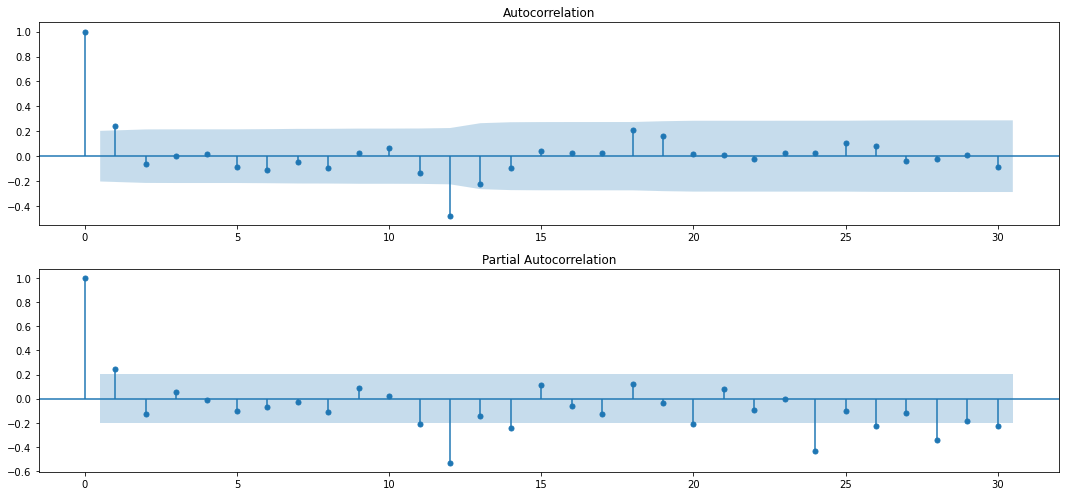

In [51]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.diff2[13:].values.squeeze(), lags=30, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.diff2[13:].values.squeeze(), lags=30, ax=ax)
plt.tight_layout()
plt.show()

In [93]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=ARIMA(df_month.diff1, order=(param[0], 1, param[1])).fit()
                    
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


In [94]:
results

[[(0, 0), 1660.0012846002492],
 [(0, 1), 1655.4952018838305],
 [(0, 2), 1657.521136921295],
 [(1, 0), 1656.886654244078],
 [(1, 1), 1657.1487799369572],
 [(1, 2), 1651.7371322091785],
 [(2, 0), 1657.2032859778267],
 [(2, 1), 1659.111145104797],
 [(2, 2), 1658.8930997688606]]

In [95]:
best_param

(1, 2)

Text(0.5, 1.0, 'Histogram of Residuals')

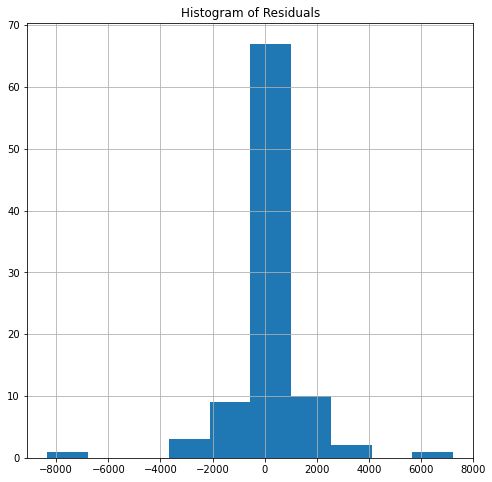

In [97]:
# Are the residuals normally distributed? 
plt.figure(figsize=(8,8))
best_model.resid[13:].hist()
plt.title('Histogram of Residuals')

High kurtosis and long tails but it does follow a roughly normal shape.

Text(0.5, 1.0, 'Time Series of Residuals')

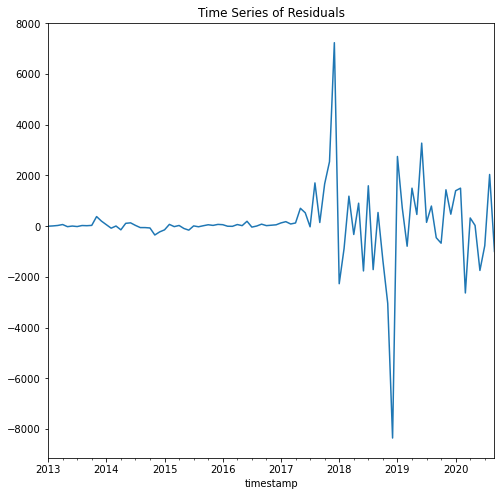

In [98]:
plt.figure(figsize=(8,8))
best_model.resid[13:].plot()
plt.title('Time Series of Residuals')

In [81]:
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])
plt.show()

Dickey–Fuller test: p=0.000000


Again some extreme values but the residuals appear to be stationary and normally distributed.

In [96]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  diff1   No. Observations:                  106
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -821.869
Date:                Wed, 25 Nov 2020   AIC                           1651.737
Time:                        23:07:51   BIC                           1662.353
Sample:                    12-31-2011   HQIC                          1656.039
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8143      0.076     10.701      0.000       0.665       0.963
ma.L1         -0.6438      0.154     -4.180      0.000      -0.946      -0.342
ma.L2         -0.3562      0.132     -2.698      0.0

My Model with an order of (1,1,2) performed the best in terms of AIC. The dataset has already been differenced to account for seasonality.